In [30]:
import pandas as pd
import numpy as np
import re
import nltk
import enchant
from guess_language import guess_language
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle

from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.metrics import classification_report_imbalanced
from sklearn import svm
from nltk.tokenize import TweetTokenizer
from Visualization import Visualization
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import decomposition
from sklearn import linear_model

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
# Read all data
fb = pd.read_json('data-sample/facebook-rotterdam-20170131.json',lines=True)
go = pd.read_json('data-sample/google-rotterdam-20170207.json',lines=True)
fac = pd.read_csv('data-sample/factual-rotterdam-20170207.csv')

In [6]:
#original size of data
fb.shape, go.shape, fac.shape

((14516, 74), (91242, 25), (53828, 30))

In [7]:
# select potential features
fb = fb[['__location','__reference','__timestamp','_id','about','awards',
    'category','category_list','description','emails','hours', 'is_published',
    'likes','location','name', 'parking','place_topics', 'price_range', 'products', 
    'restaurant_specialties','talking_about_count','website']]

go = go[['_id','address_components','formatted_address','loc','name',
    'rating','price_level','vicinity']]

fac = fac[['name','address','locality','region','latitude',
     'longitude','neighborhood','hours','existence']]

In [8]:
#get location 
fb = fb.drop(fb.index[[482,8276,8280]])
fb['longitude'] = [i['coordinates'][1] for i in fb['__location']]
fb['latitude'] = [i['coordinates'][0] for i in fb['__location']]

In [ ]:
#fb.hours = fb.hours.fillna('0')
#hours = fb.hours.unique()
#fb['hours'] = fb.hours.replace(hours,range(1,len(hours)+1))

In [9]:
# preprocess interesting features
fb = fb.dropna(subset=['likes'],how='any')
fb = fb.reset_index()
fb['likes'] = [fb.likes[i]['$numberLong'] for i in range(len(fb))]
go['id'] = [go['_id'][i]['$oid'] for i in range(len(go))]

In [10]:
# filter most informative fields
fb = fb[['_id','name','category','price_range','about','latitude','longitude','description','likes']]
go = go[['id','name','rating','price_level']]
fac = fac[['name','hours','existence']]

In [11]:
tmp_df = pd.merge(fb,go, how = 'left', left_on = 'name', right_on = 'name')

In [12]:
# label price
pd.options.mode.chained_assignment = None
df = tmp_df[['name','category','price_range','price_level','rating','about','latitude','longitude',
            'description','likes']]

df['price'] = np.NaN

for i in range(len(df)):
    if isinstance(df['price_range'][i], str):
        df['price'][i] = df['price_range'][i].count('$')
    elif not np.isnan(df['price_level'][i]):
        df['price'][i] = df['price_level'][i]

In [13]:
#select data to train price estimator
data = df[['name','category','rating','about','price','latitude','longitude','description','likes']].loc[df['price'] >= 0]
data = data.reset_index()
del data['index']

In [14]:
# labels for categories
home = {'home','improvement'}
web = {'web', 'designer', 'website','personal website'}
salon = {'hair','nail','salon','fashion'}
media = {'media','news','telecom'}
school = {'school','education','college','university','library'}
health = {'medical','hospital','health','clinic', 'doctor'}
gov = {'government','public services','community','non-profit'}
public = {'landmark','historical place','geographical','public place','neighborhood','city'}
fitness = {'fitness','beauty','spa','care','trainer','club','performance','coach'}
travel = {'traveling','tour','agency','travel','hotel','lodging','attractions','things to do'}
event = {'event','planning','planner','agency'}
sport = {'sports','arena','stadium','entertainment'}
ent = {'arts','recreation','movie','museum','art','gallery','artist'}
comp = {'local', 'business','professional', 'service','organization',
        'consulting','company','business','professional','finance','religious'}
shop = {'shopping','retail','grocery','store','book','electronics','jewelry','watches','apparel'}
bar = {'bar','food','beverage','cafe','nightlife','restaurant','café'}
others = {'pet','automotive'}

categ_set = home | web | salon | media | school | health | gov | public | fitness | travel | event | sport | ent | comp | shop | bar | others
categ = [home, web, salon, media, school, health, gov, public, fitness, travel, event,
         sport, ent, comp,shop,bar,others]

In [15]:
d = enchant.Dict("en_US")
def label_category(category):
    
    tmp_wrd = nltk.wordpunct_tokenize(category)
    label = np.NaN
    
    for word in tmp_wrd:
        if d.check(word):
            unique = 0
            
            for i in range(len(categ)):
                if word.lower() in categ[i]:
                    if unique != 1:
                        label = i
                        unique = 1

    return label          

In [16]:
data['category'] = [label_category(i) for i in data['category']]
data.about = data.about.fillna('none')

In [17]:
#include stop words
stop_du = set(stopwords.words('dutch'))
stop_en = set(stopwords.words('english'))
stop_others = {'www','com','visit','rotterdam','netherlands','pagina','welkom','vind','emails', 'based',
             'kart', 'based', 'info', 'follow','specialist','email','online','airport'}

stops = stop_du | stop_en | stop_others | categ_set

In [18]:
def remove_stops(data,columnName):
    
    reviews = []

    for review in data[columnName]:
        review = nltk.wordpunct_tokenize(review)
        text_prosc = [word.lower() for word in review if not word.lower() in stops and word.isalpha()]
        cleaned_text = " ".join(text_prosc)
        reviews.append(cleaned_text)
    return reviews

In [19]:
data['rel_words'] = remove_stops(data,'about')

In [21]:
data['language'] = [guess_language(text) for text in data.rel_words]

In [22]:
gldn_data = go[['name','rating','price_level']]

In [23]:
tmp_df = pd.merge(gldn_data, fb, how = 'left', left_on = 'name', right_on = 'name')

In [24]:
lab_lang = data.language.unique()
data['language'] = data.language.replace(lab_lang, range(1,len(lab_lang)+1))

In [25]:
data = data[['category','rating','price','rel_words','language','latitude','longitude','likes']]

In [26]:
data = data.fillna(data.rating.mean())

In [28]:
#ADD MORE FEATURES
add_feats = data[['category','rating','latitude','longitude','price']]
a_feats = add_feats.values

In [34]:
train_size = 0.7
RANDOM_STATE = 42
x_fts = a_feats 


"""
pca = decomposition.PCA(n_components=10)
pca.fit(x_fts)
x_fts = pca.transform(x_fts)
"""

    
train_size = int(len(x_fts)* train_size)
#shuffle(data)

x_train, y_train = x_fts[0:train_size], data['likes'][0:train_size]
X_test, Y_test = x_fts[train_size:], data['likes'][train_size:]

In [33]:
#ros = RandomUnderSampler(random_state=RANDOM_STATE)

#x_train, y_train = ros.fit_sample(x_train, y_train)
#X_test, Y_test = ros.fit_sample(X_test, Y_test)

In [36]:
cross_validation =   StratifiedKFold (y_train,n_folds=5, random_state=RANDOM_STATE)

scores = []
confusion_matrices = []
clf_models = []
avgs = []

for train_index,test_index in cross_validation:

    clf = None

    dx_train, dy_train = x_train[train_index], y_train[train_index]
    dx_test, dy_test = x_train[test_index], y_train[test_index]
    
    #clf = MultinomialNB()#.fit(dx_train, dy_train)
    #clf = RandomForestClassifier(n_estimators= 25, n_jobs=-1)
    #clf = KNeighborsClassifier(n_neighbors=3)
    clf = linear_model.LinearRegression()
    clf.fit(dx_train, dy_train)
    clf_models.append(clf)
    
    # Saving the scores.
    test_score = clf.score(dx_test, dy_test)
    """
    test_preds = clf.predict(dx_test)
    rep = classification_report_imbalanced(dy_test, test_preds)
    txt_rep = nltk.word_tokenize(rep[428:])
    
    avg_total = [float(txt_rep[i]) for i in range(3,len(txt_rep))]
    avgs.append(avg_total)
    scores.append(test_score)


    # Saving the confusion matrices.
    data_classes_pred = clf.predict(dx_test) 
    cm = confusion_matrix(dy_test, test_preds)
    confusion_matrices.append(cm)
    
print('Average precision :', str(np.mean([avgs[i][0] for i in range(len(avgs))])))
print('Average recall :', str(np.mean([avgs[i][1] for i in range(len(avgs))])))
print('Average F-score :', str(np.mean([avgs[i][3] for i in range(len(avgs))])))

"""

/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


In [37]:
#clf = MultinomialNB()#.fit(x_train, y_train)
#clf = RandomForestClassifier(n_estimators= 25, n_jobs=-1,random_state=RANDOM_STATE)
#clf = svm.SVC(decision_function_shape='ovo',random_state=RANDOM_STATE,probability=True)
#clf = KNeighborsClassifier(n_neighbors=5)
clf = linear_model.LinearRegression()
clf.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
test_preds = clf.predict(X_test)

In [39]:
clf.score(X_test,Y_test)

-2.7182055957266686

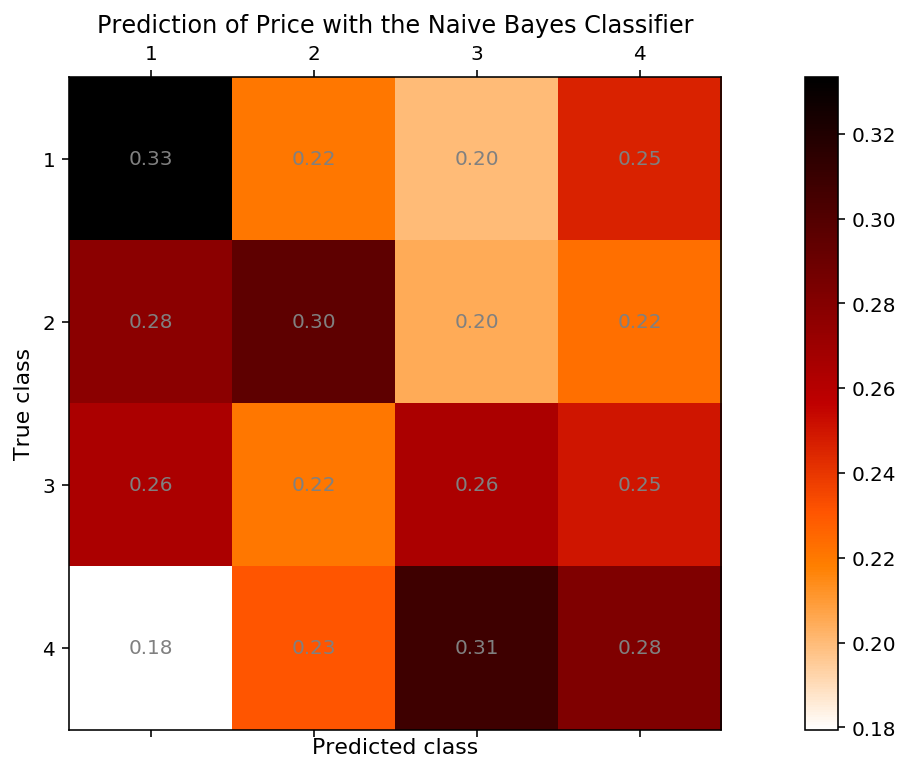

In [349]:
vis.plot_confusion_matrix(Y_test, test_preds, 
                          'Prediction of Price with the Naive Bayes Classifier',color='gray')